In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import numpy as np
import pandas as pd
import pickle
import gc
import re
import collections
import math
from tqdm.notebook import tqdm
from pytorch_memlab import MemReporter
from torchinfo import summary
# ここから自作
import model
import result
import mode
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, target, transform=None):
        self.transform = transform
        self.data = data
        self.target = target
   
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        out_data = self.data[index]
        out_target = self.target[index]
        
        return out_data, out_target

In [3]:
# 時刻を表示してくれるようになるprint関数のwrapper
def datePrint(*args, **kwargs):
    from datetime import datetime
    print(datetime.now().strftime('[%Y/%m/%d %H:%M:%S] '), end="")
    print(*args, **kwargs)

In [4]:
def load_vocab(vocab_file):
    """Loads a vocabulary file into a dictionary."""
    vocab = collections.OrderedDict()
    with open(vocab_file, "r", encoding="utf-8") as reader:
        tokens = reader.readlines()
    for index, token in enumerate(tokens):
        token = token.rstrip("\n")
        vocab[token] = index
    return vocab

In [5]:
# # bert仕様から，オリジナル仕様に加工してますね
# df = pd.read_table('../data/make/forbert/dev.tsv')
# dev = df['sequence'].str.split(' ', expand=True).replace(vocab).drop(columns=508)
# dev = torch.tensor(dev.values).to(torch.float)
# print(dev.shape)
# pickle.dump(dev, open(f"../data/make/forbert/dev.pkl", "wb"))

# df = pd.read_table('../data/make/forbert/train.tsv')
# train = df['sequence'].str.split(' ', expand=True).replace(vocab)
# print(train)
# train = train.drop(columns=508)
# train = torch.tensor(train.values).to(torch.float)
# print(train.shape)
# pickle.dump(train, open(f"../data/make/forbert/train.pkl", "wb"))

In [6]:
# # kmer読み込み
# vocab = load_vocab("../data/make/forbert/vocab.txt")

# dev = pickle.load(open("../data/make/forbert/dev.pkl","rb"))
# print(dev.shape)
# train = pickle.load(open("../data/make/forbert/train.pkl","rb"))
# print(train.shape)

# target_dev = torch.tensor(pickle.load(open("../data/make/forbert/target_dev.pkl","rb")))
# target_dev = torch.flip(target_dev, dims=[1]).to(torch.float)
# print(target_dev.shape)

# target_train = torch.tensor(pickle.load(open("../data/make/forbert/target_train.pkl","rb")))
# target_train = torch.flip(target_train, dims=[1]).to(torch.float)
# print(target_train.shape)

# input_all = torch.cat([train, dev], dim=0)
# target_all = torch.cat([target_train, target_dev], dim=0)
# print(input_all.shape)
# print(target_all.shape)

# dataset = model.Dataset(input_all, target_all)
# train_dataset, val_dataset = torch.utils.data.random_split(dataset, [180000, 20000])

In [9]:
datePrint("loading pickle data")
# input1 = torch.tensor(pickle.load(open("../data/make/maxspan100/seq_1.pkl","rb")).astype('float'))
# input2= torch.tensor(pickle.load(open("../data/make/maxspan100/seq_2.pkl","rb")).astype('float'))
# input3 = torch.tensor(pickle.load(open("../data/make/maxspan100/seq_3.pkl","rb")).astype('float'))
# input4 = torch.tensor(pickle.load(open("../data/make/maxspan100/seq_4.pkl","rb")).astype('float'))
# input5 = torch.tensor(pickle.load(open("../data/make/maxspan100/seq_5.pkl","rb")).astype('float'))
input1 = torch.tensor(pickle.load(open("../data/make/maxspan100/seq_1.pkl","rb")))
target1 = torch.tensor(pickle.load(open("../data/make/maxspan100/target_1.pkl","rb"))).float()
target1 = torch.flip(target1, dims=[1])
dataset = model.Dataset(input1, target1)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [400000, 100000])
print(input1.shape)
print(input1[:2])
print(target1.shape)
print(target1[:2])


# target1 = torch.tensor(pickle.load(open("../data/make/maxspan100/target_1.pkl","rb"))).float()
# target1 = torch.flip(target1, dims=[1])
# target2 = torch.tensor(pickle.load(open("../data/make/maxspan100/target_2.pkl","rb"))).float()
# target2 = torch.flip(target2, dims=[1])
# target3 = torch.tensor(pickle.load(open("../data/make/maxspan100/target_3.pkl","rb"))).float()
# target3 = torch.flip(target3, dims=[1])
# target4 = torch.tensor(pickle.load(open("../data/make/maxspan100/target_4.pkl","rb"))).float()
# target4 = torch.flip(target4, dims=[1])
# target5 = torch.tensor(pickle.load(open("../data/make/maxspan100/target_5.pkl","rb"))).float()
# target5 = torch.flip(target5, dims=[1])

# input_all = torch.cat([input1, input2, input3, input4, input5], dim=0)
# target_all = torch.cat([target1, target2, target3, target4, target5], dim=0)
# print(input_all.shape)
# print(input_all[:2])
# print(target_all.shape)
# print(target_all[:2])

# dataset = model.Dataset(input_all, target_all)
# train_dataset, val_dataset = torch.utils.data.random_split(dataset, [400000, 100000])

[2022/01/27 06:44:04] loading pickle data


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


torch.Size([500000, 512])
tensor([[1., 3., 2.,  ..., 3., 4., 4.],
        [3., 3., 2.,  ..., 1., 2., 1.]])
torch.Size([500000, 508])
tensor([[1.2987, 1.4003, 1.4025,  ..., 1.3862, 1.3948, 1.3499],
        [3.2473, 3.3532, 3.4319,  ..., 0.1844, 0.1847, 0.1829]])


In [10]:
def lambda_epoch(epoch):
    # スケジューラの設定
    max_epoch = 20
    return math.pow((1-epoch/max_epoch), 0.9)

In [11]:
# costom loss軍団
    
class CosineLoss(nn.Module):
    def __init__(self):
        super(CosineLoss, self).__init__()

    def forward(self, outputs, targets):
        return torch.sum(1 - nn.functional.cosine_similarity(outputs, targets, dim=-1, eps=1e-6))

class HyperbolicLoss(nn.Module):
    def __init__(self):
        super(HyperbolicLoss, self).__init__()

    def forward(self, u, v, epsilon=1e-7):
        sqdist = torch.sum((u - v) ** 2, dim=-1)
        squnorm = torch.sum(u ** 2, dim=-1)
        sqvnorm = torch.sum(v ** 2, dim=-1)
        x = 1 + 2 * sqdist / ((1 - squnorm) * (1 - sqvnorm)) + epsilon
        z = torch.sqrt(x ** 2 - 1)
        return torch.sum(z)

# from geomstats.geometry.poincare_ball import PoincareBall
# class PoincareBallLoss(nn.Module):
#     def __init__(self):
#         super(PoincareBallLoss, self).__init__()
        
#     def forward(self, output, target):
#         output = output.cpu().detach().numpy()
#         target = target.cpu().detach().numpy()
#         return float(PoincareBall(dim=8).metric.dist(output[0], target[0]))


losses = [nn.MSELoss]
lrs = [5e-4, 1e-4, 1e-3]
opts = [optim.Adam, optim.RMSprop, optim.Adamax]

optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0005
    weight_decay: 0
)
Epoch 1/20
val Loss:12.1496 Timer:11.1199
Epoch 2/20
train Loss:8.8476 Timer:228.3418
val Loss:6.9670 Timer:10.8717
Epoch 3/20
train Loss:5.6305 Timer:224.2670
val Loss:4.3118 Timer:11.3397
Epoch 4/20
train Loss:3.6787 Timer:223.3710
val Loss:3.2096 Timer:10.7400
Epoch 5/20
train Loss:2.5969 Timer:223.8439
val Loss:2.3149 Timer:17.1856


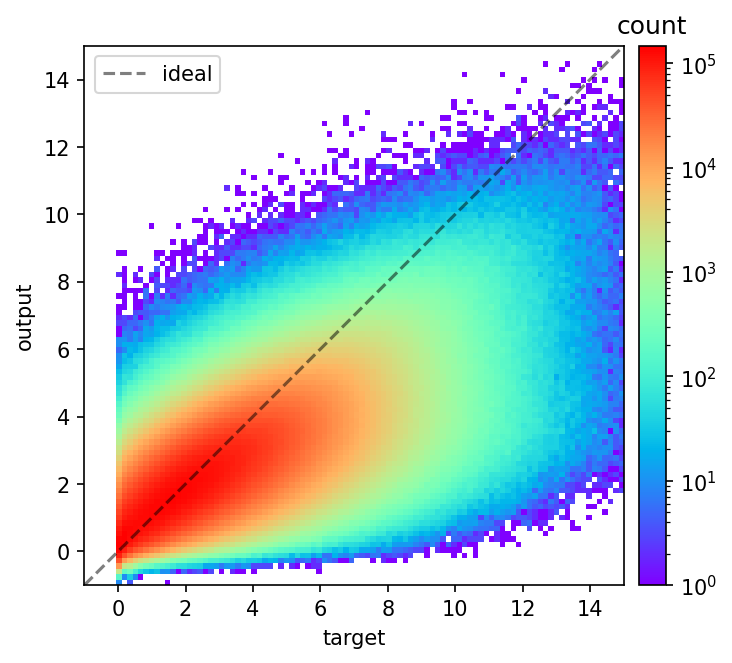

Epoch 6/20
train Loss:2.0961 Timer:225.1338
val Loss:1.9853 Timer:10.6292
Epoch 7/20
train Loss:1.9250 Timer:225.0026
val Loss:1.9168 Timer:11.1640
Epoch 8/20
train Loss:1.8682 Timer:224.4724
val Loss:1.8759 Timer:10.8114
Epoch 9/20
train Loss:1.8300 Timer:224.5391
val Loss:1.8470 Timer:11.1633
Epoch 10/20
train Loss:1.7976 Timer:223.9373
val Loss:1.8267 Timer:17.3548


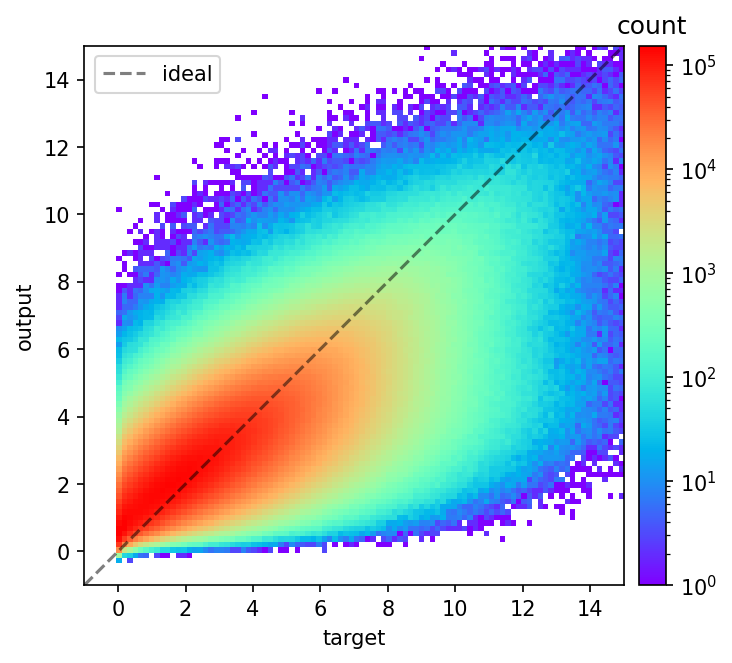

Epoch 11/20
train Loss:1.7693 Timer:224.9289
val Loss:1.8102 Timer:10.6042
Epoch 12/20
train Loss:1.7443 Timer:223.9248
val Loss:1.7825 Timer:10.6709
Epoch 13/20
train Loss:1.7222 Timer:224.0690
val Loss:1.7707 Timer:10.6785
Epoch 14/20
train Loss:1.7025 Timer:224.7408
val Loss:1.7741 Timer:10.5609
Epoch 15/20
train Loss:1.6846 Timer:225.5434
val Loss:1.7466 Timer:18.4573


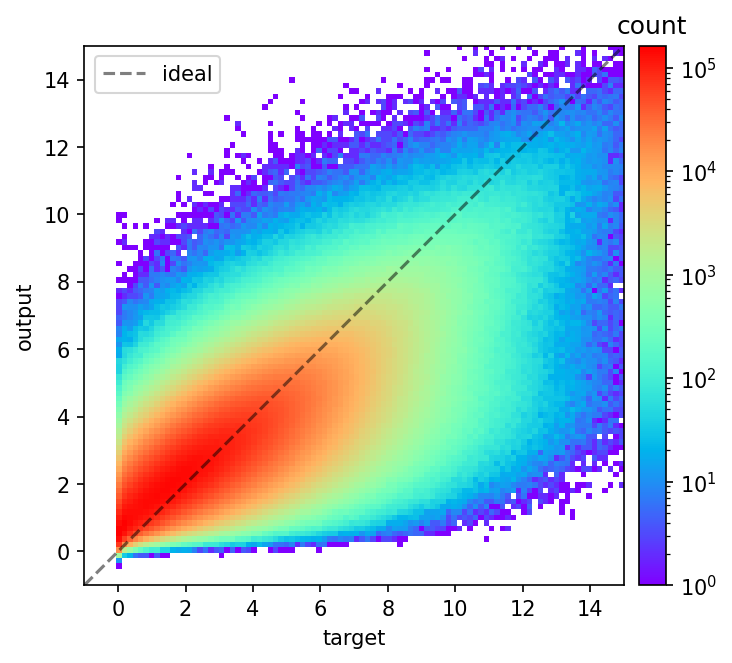

Epoch 16/20
train Loss:1.6682 Timer:226.9443
val Loss:1.7302 Timer:11.2356
Epoch 17/20
train Loss:1.6533 Timer:225.1097
val Loss:1.7226 Timer:11.0736
Epoch 18/20
train Loss:1.6396 Timer:225.5109
val Loss:1.7178 Timer:10.7171
Epoch 19/20
train Loss:1.6269 Timer:224.7670
val Loss:1.7160 Timer:10.8329
Epoch 20/20
train Loss:1.6151 Timer:226.6583
val Loss:1.7072 Timer:17.9391


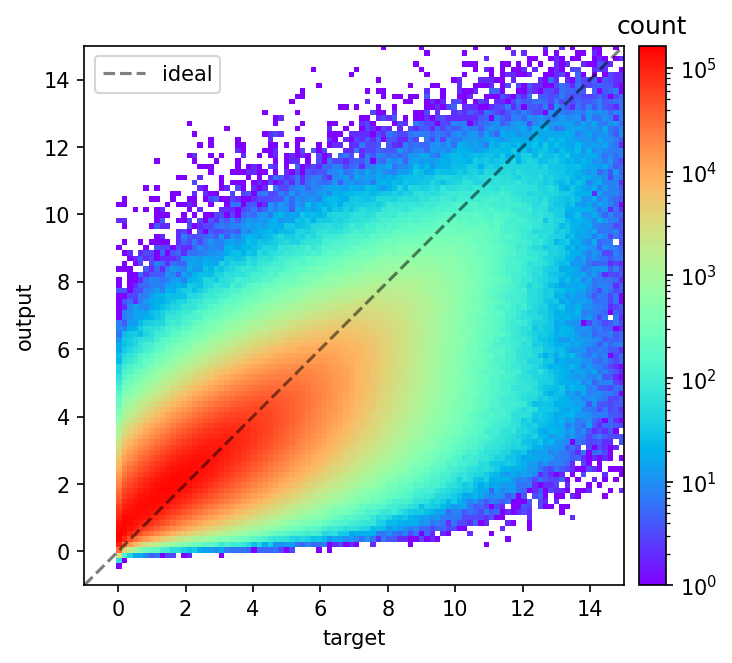

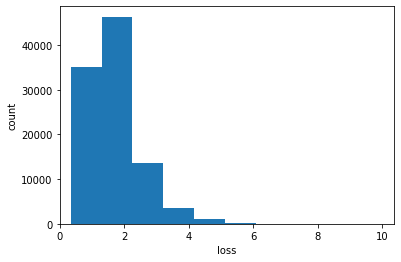

1.7072207


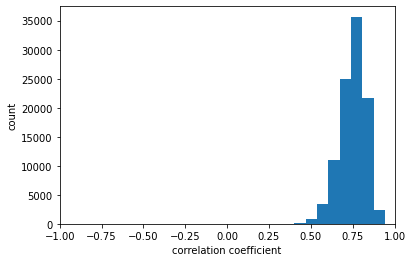

0.7499400405150856
optimizer: RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.0005
    momentum: 0
    weight_decay: 0
)
Epoch 1/20
val Loss:11.6186 Timer:10.3592
Epoch 2/20
train Loss:8.7132 Timer:220.0933
val Loss:6.5382 Timer:10.7712
Epoch 3/20
train Loss:5.2631 Timer:219.8008
val Loss:4.1624 Timer:10.7070
Epoch 4/20
train Loss:3.2152 Timer:220.3788
val Loss:2.6734 Timer:10.7157
Epoch 5/20
train Loss:2.2452 Timer:219.4934
val Loss:2.0976 Timer:17.7095


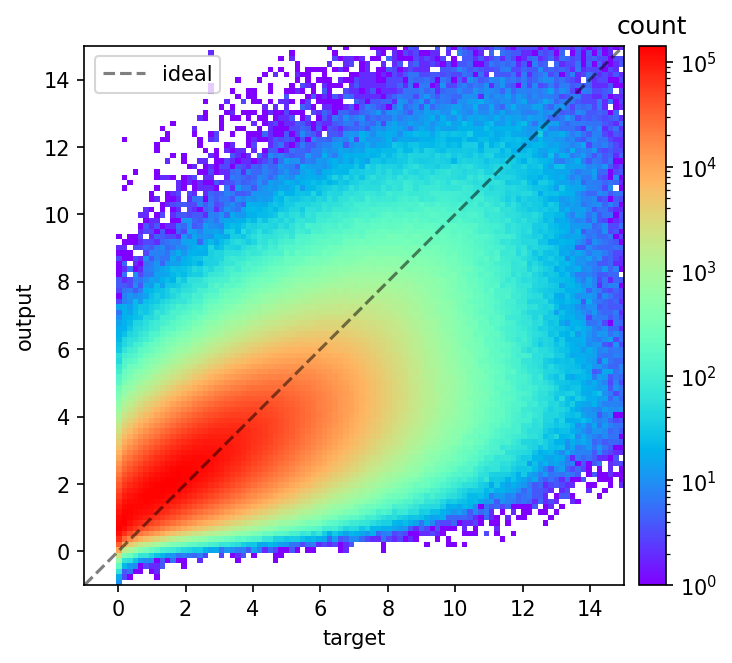

Epoch 6/20
train Loss:2.0203 Timer:221.0469
val Loss:2.0310 Timer:10.7996
Epoch 7/20
train Loss:1.9577 Timer:221.0750
val Loss:1.9651 Timer:10.9010
Epoch 8/20
train Loss:1.9085 Timer:220.5662
val Loss:1.9197 Timer:10.8470
Epoch 9/20
train Loss:1.8675 Timer:220.3102
val Loss:1.8921 Timer:10.6733
Epoch 10/20
train Loss:1.8328 Timer:220.6646
val Loss:1.9155 Timer:17.7872


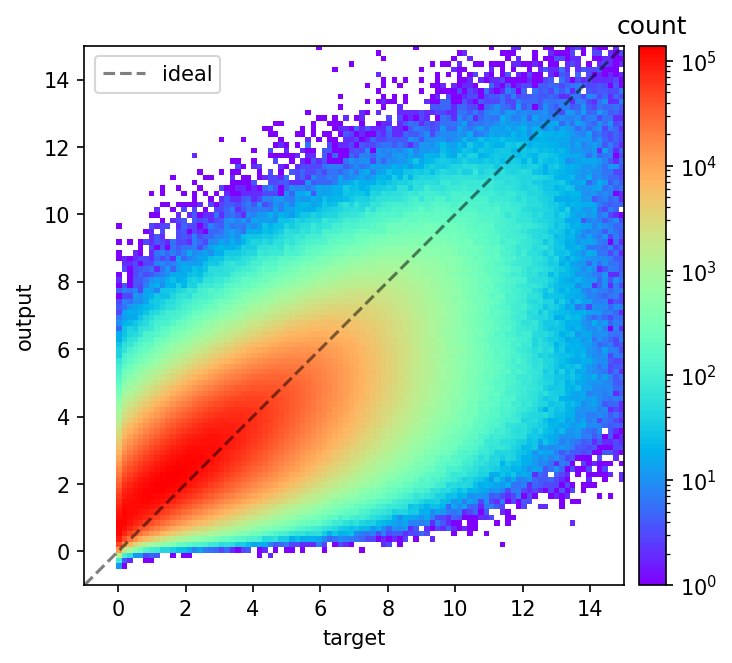

Epoch 11/20
train Loss:1.8026 Timer:220.4171
val Loss:1.8313 Timer:11.2447
Epoch 12/20
train Loss:1.7762 Timer:220.5578
val Loss:1.8271 Timer:10.9679
Epoch 13/20
train Loss:1.7533 Timer:222.9268
val Loss:1.7980 Timer:11.2191
Epoch 14/20
train Loss:1.7328 Timer:220.3267
val Loss:1.7805 Timer:10.9845
Epoch 15/20
train Loss:1.7146 Timer:223.5953
val Loss:1.7552 Timer:19.3330


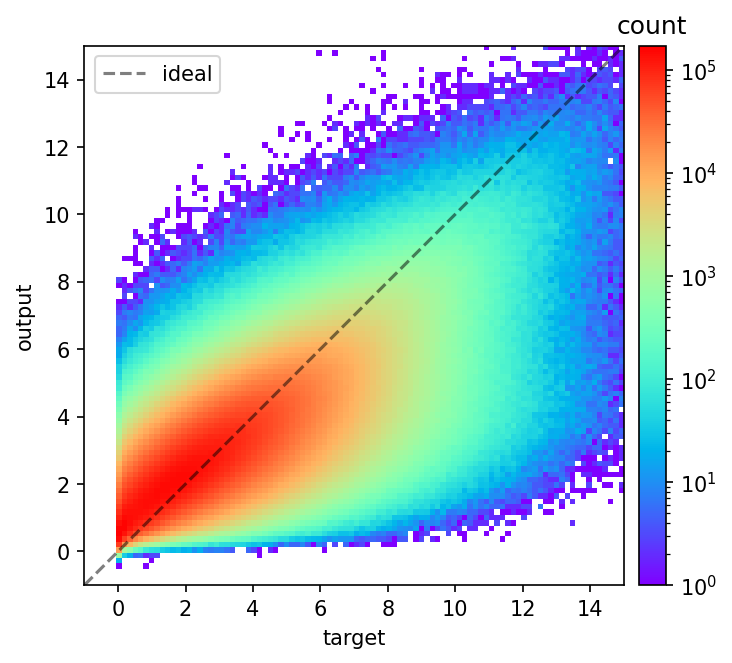

Epoch 16/20
train Loss:1.6986 Timer:221.2802
val Loss:1.7436 Timer:14.1636
Epoch 17/20
train Loss:1.6842 Timer:219.6895
val Loss:1.7352 Timer:10.7061
Epoch 18/20
train Loss:1.6717 Timer:223.4828
val Loss:1.7278 Timer:11.9466
Epoch 19/20
train Loss:1.6606 Timer:229.5633
val Loss:1.7159 Timer:10.6894
Epoch 20/20
train Loss:1.6508 Timer:224.0760
val Loss:1.7134 Timer:18.0420


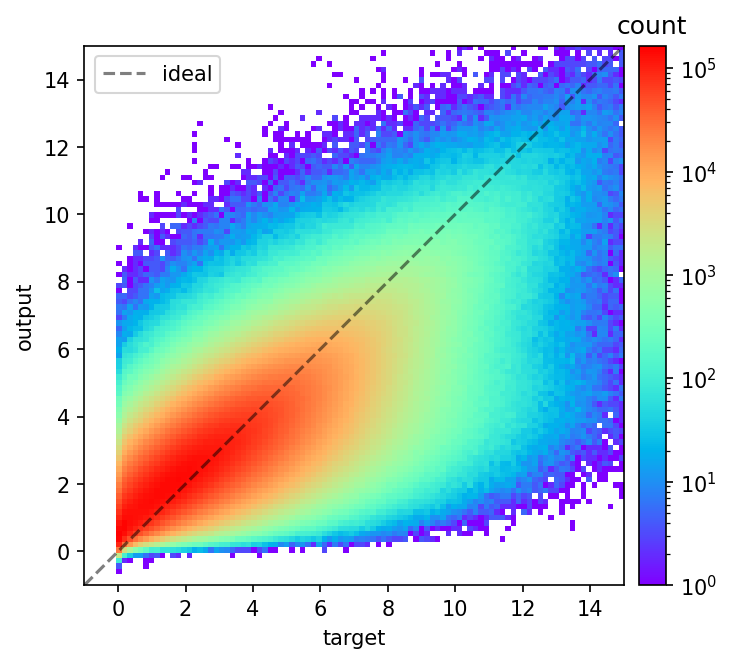

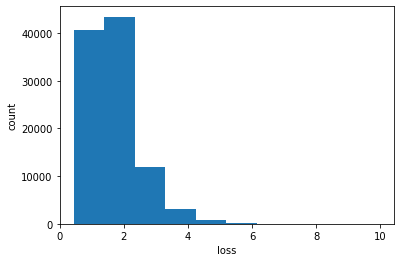

1.7134011


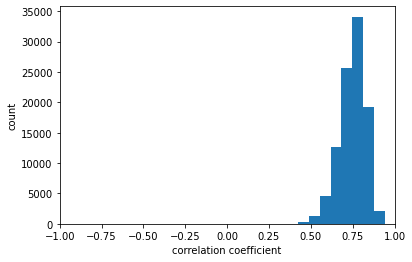

0.7488295237306452
optimizer: Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0005
    weight_decay: 0
)
Epoch 1/20
val Loss:11.9387 Timer:10.3960
Epoch 2/20
train Loss:8.9160 Timer:227.6570
val Loss:6.9363 Timer:11.8121
Epoch 3/20
train Loss:5.5674 Timer:228.6709
val Loss:4.4919 Timer:11.0007
Epoch 4/20
train Loss:3.4707 Timer:230.1699
val Loss:2.8442 Timer:10.7750
Epoch 5/20
train Loss:2.4533 Timer:229.6853
val Loss:2.2664 Timer:19.2991


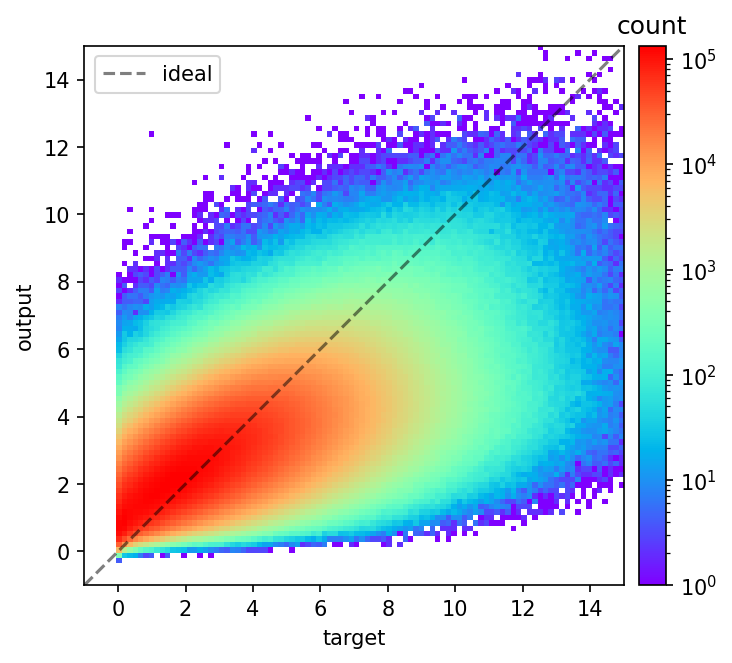

Epoch 6/20
train Loss:2.2155 Timer:230.6528
val Loss:2.2039 Timer:10.7835
Epoch 7/20
train Loss:2.1632 Timer:229.8069
val Loss:2.1663 Timer:10.7720
Epoch 8/20
train Loss:2.1230 Timer:230.7031
val Loss:2.1364 Timer:10.6834
Epoch 9/20
train Loss:2.0898 Timer:228.9884
val Loss:2.1076 Timer:10.6183
Epoch 10/20
train Loss:2.0616 Timer:227.3192
val Loss:2.0819 Timer:19.4409


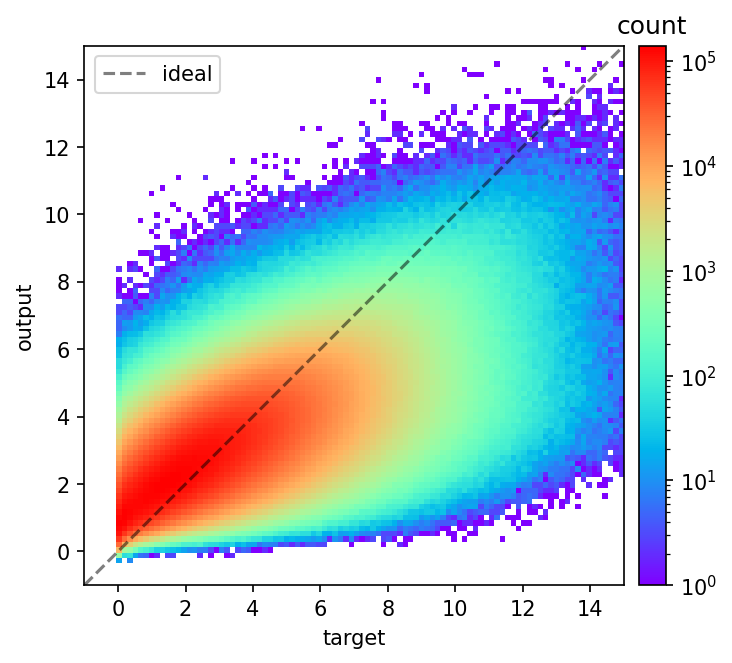

Epoch 11/20
train Loss:2.0368 Timer:229.9964
val Loss:2.0737 Timer:10.7048
Epoch 12/20
train Loss:2.0154 Timer:229.1329
val Loss:2.0507 Timer:10.8725
Epoch 13/20
train Loss:1.9965 Timer:229.2407
val Loss:2.0356 Timer:10.6336
Epoch 14/20
train Loss:1.9797 Timer:227.8797
val Loss:2.0243 Timer:10.7343
Epoch 15/20
train Loss:1.9647 Timer:228.1146
val Loss:2.0209 Timer:18.5068


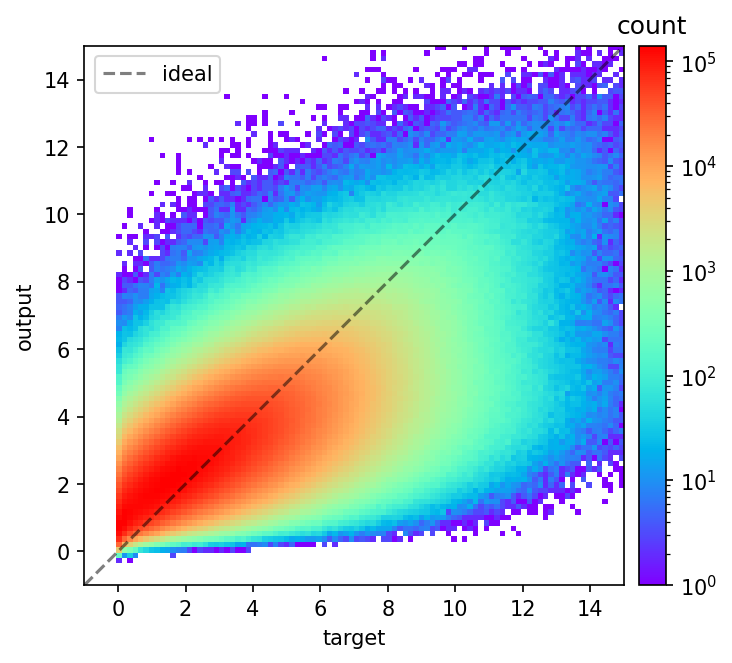

Epoch 16/20
train Loss:1.9516 Timer:230.1404
val Loss:2.0116 Timer:10.4550
Epoch 17/20
train Loss:1.9396 Timer:227.1950
val Loss:2.0037 Timer:10.7757
Epoch 18/20
train Loss:1.9291 Timer:234.1993
val Loss:2.0015 Timer:11.8998
Epoch 19/20
train Loss:1.9197 Timer:233.3840
val Loss:1.9980 Timer:12.4699
Epoch 20/20
train Loss:1.9114 Timer:231.3348
val Loss:1.9959 Timer:19.0455


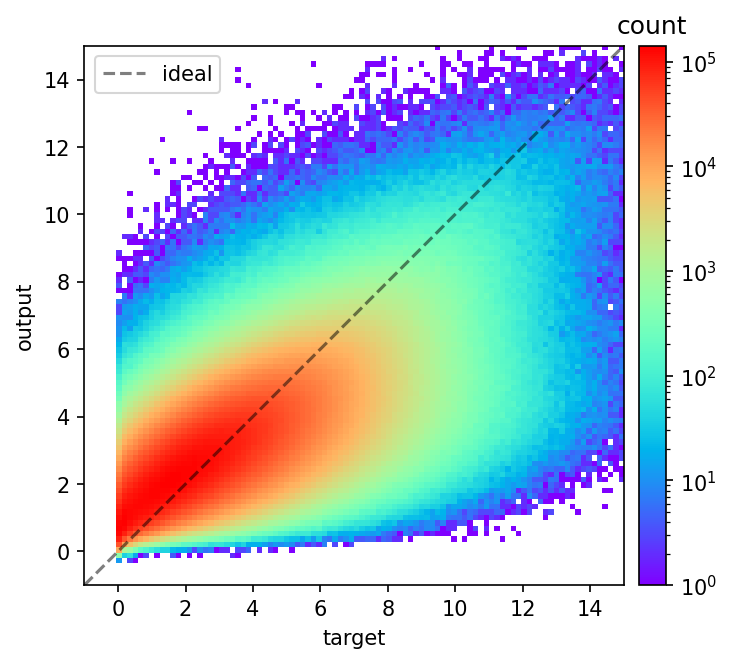

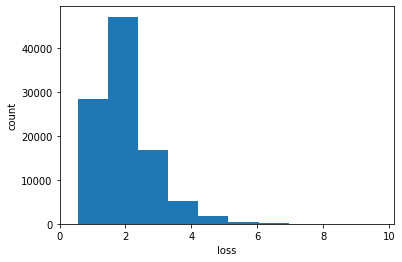

1.9958935


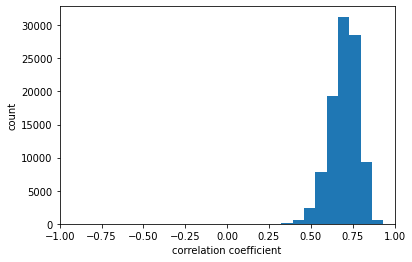

0.698296917481439
optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0
)
Epoch 1/20
val Loss:12.0723 Timer:10.3664
Epoch 2/20
train Loss:10.5472 Timer:226.7206
val Loss:9.7245 Timer:10.9119
Epoch 3/20
train Loss:9.5563 Timer:227.6099
val Loss:9.1148 Timer:10.9406
Epoch 4/20
train Loss:8.7549 Timer:226.7227
val Loss:8.1454 Timer:10.6919
Epoch 5/20
train Loss:8.0248 Timer:229.4296
val Loss:7.8405 Timer:19.1019


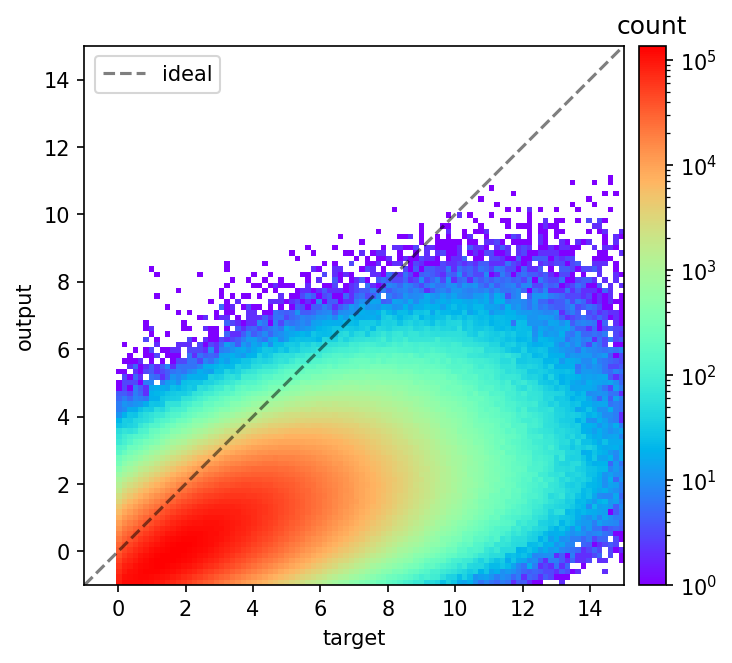

Epoch 6/20
train Loss:7.3741 Timer:226.0712
val Loss:7.0601 Timer:10.6796
Epoch 7/20
train Loss:6.7967 Timer:228.8783
val Loss:6.3730 Timer:11.3492
Epoch 8/20
train Loss:6.2883 Timer:223.6089
val Loss:5.8188 Timer:10.6485
Epoch 9/20
train Loss:5.8405 Timer:227.5686
val Loss:5.5265 Timer:11.0803
Epoch 10/20
train Loss:5.4462 Timer:227.9126
val Loss:5.2116 Timer:18.2568


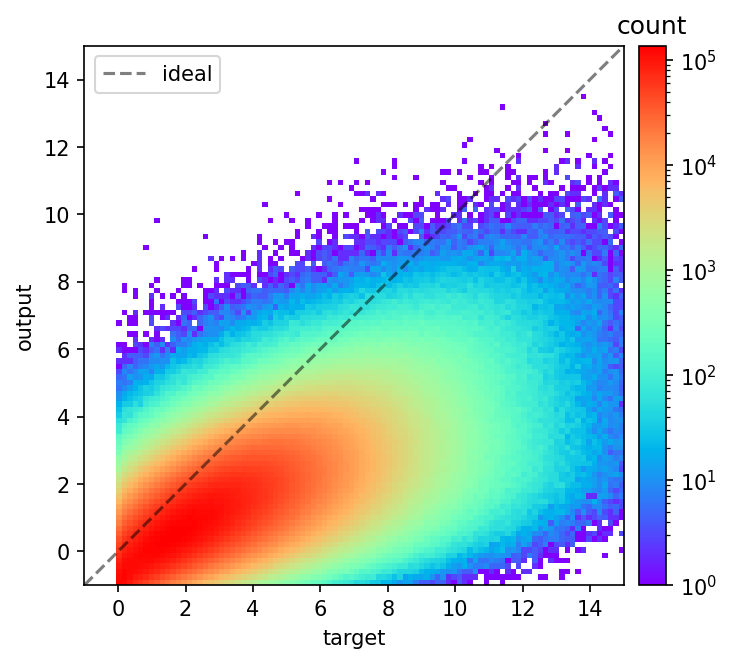

Epoch 11/20
train Loss:5.1002 Timer:229.5558
val Loss:5.0514 Timer:10.7845
Epoch 12/20
train Loss:4.7972 Timer:226.9367
val Loss:4.7286 Timer:10.7509
Epoch 13/20
train Loss:4.5337 Timer:228.0639
val Loss:4.5600 Timer:10.6829
Epoch 14/20
train Loss:4.3058 Timer:225.9852
val Loss:4.2414 Timer:10.7327
Epoch 15/20
train Loss:4.1101 Timer:226.8191
val Loss:3.9634 Timer:17.8111


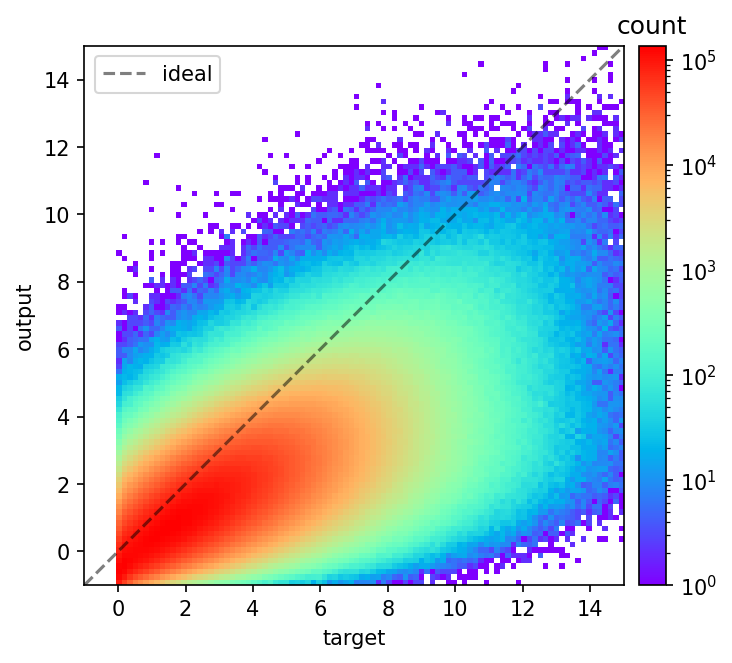

Epoch 16/20
train Loss:3.9445 Timer:229.2003
val Loss:3.8050 Timer:10.8815
Epoch 17/20
train Loss:3.8064 Timer:227.6513
val Loss:3.7939 Timer:10.7606
Epoch 18/20
train Loss:3.6940 Timer:229.8938
val Loss:3.7567 Timer:11.1525
Epoch 19/20
train Loss:3.6057 Timer:229.7323
val Loss:3.5691 Timer:10.7803
Epoch 20/20
train Loss:3.5409 Timer:227.6139
val Loss:3.5875 Timer:18.0666


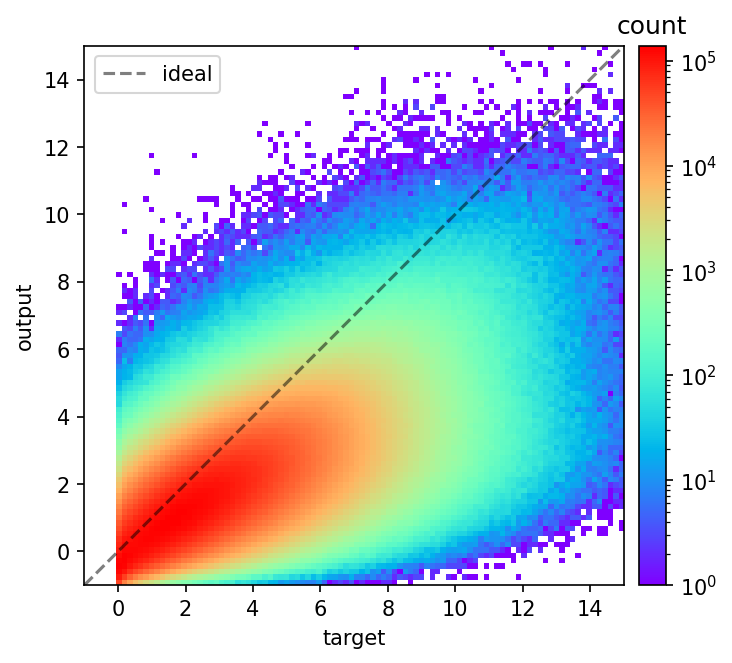

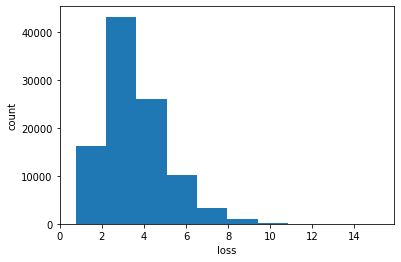

3.5875006


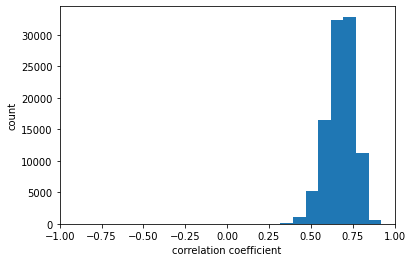

0.676911449825024
optimizer: RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.0001
    momentum: 0
    weight_decay: 0
)
Epoch 1/20
val Loss:12.2298 Timer:10.6206
Epoch 2/20
train Loss:10.4081 Timer:222.0780
val Loss:9.9216 Timer:10.6956
Epoch 3/20
train Loss:9.4332 Timer:221.1206
val Loss:9.1082 Timer:10.6679
Epoch 4/20
train Loss:8.6047 Timer:220.9774
val Loss:8.0793 Timer:10.8941
Epoch 5/20
train Loss:7.8686 Timer:222.3113
val Loss:7.4647 Timer:18.0207


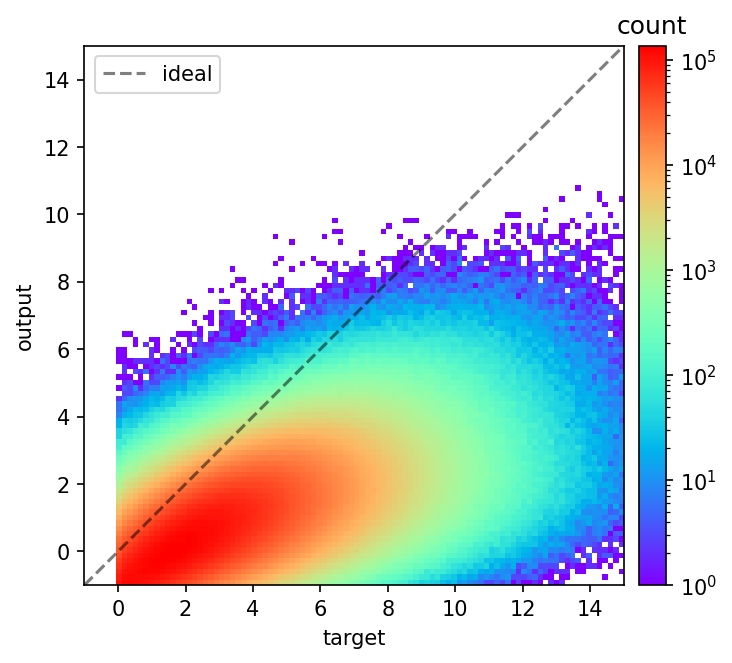

Epoch 6/20
train Loss:7.2160 Timer:222.2393
val Loss:6.8408 Timer:10.8813
Epoch 7/20
train Loss:6.6384 Timer:223.1466
val Loss:6.6546 Timer:10.8042
Epoch 8/20
train Loss:6.1267 Timer:224.9155
val Loss:5.6062 Timer:10.7436
Epoch 9/20
train Loss:5.6753 Timer:223.7815
val Loss:5.4178 Timer:10.8938
Epoch 10/20
train Loss:5.2781 Timer:222.5919
val Loss:5.1872 Timer:18.6730


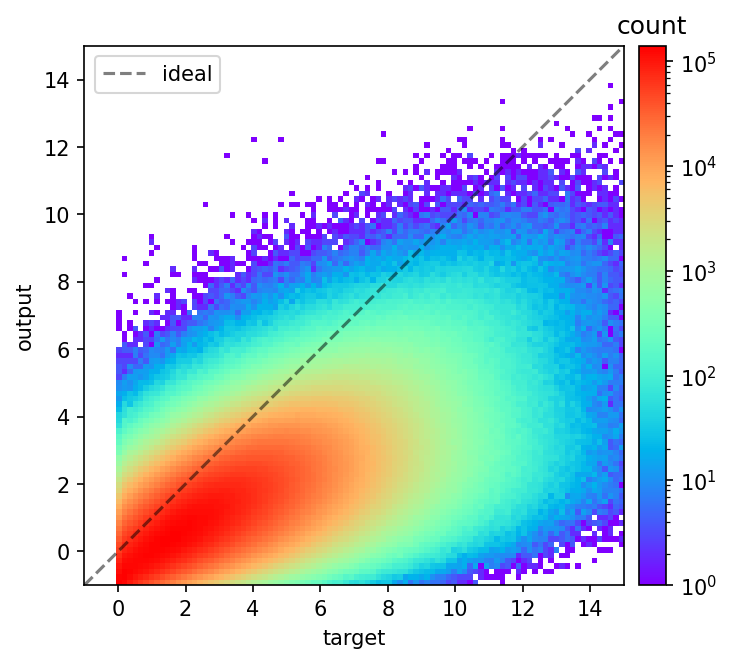

Epoch 11/20
train Loss:4.9298 Timer:224.4200
val Loss:4.6418 Timer:11.2900
Epoch 12/20
train Loss:4.6258 Timer:223.7053
val Loss:4.4385 Timer:10.6742
Epoch 13/20
train Loss:4.3619 Timer:220.8580
val Loss:4.3306 Timer:10.6516
Epoch 14/20
train Loss:4.1348 Timer:223.0403
val Loss:4.1685 Timer:10.8532
Epoch 15/20
train Loss:3.9409 Timer:225.4265
val Loss:4.0578 Timer:18.2350


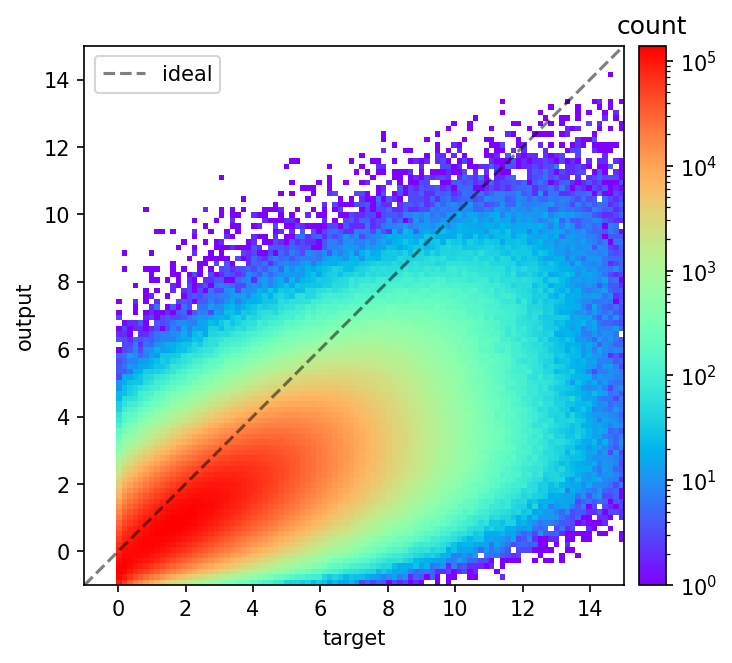

Epoch 16/20
train Loss:3.7772 Timer:221.8726
val Loss:3.7115 Timer:10.7545
Epoch 17/20
train Loss:3.6413 Timer:222.1311
val Loss:3.7028 Timer:11.1483
Epoch 18/20
train Loss:3.5313 Timer:224.1537
val Loss:3.5476 Timer:11.1752
Epoch 19/20
train Loss:3.4454 Timer:222.8433
val Loss:3.4587 Timer:11.1463
Epoch 20/20
train Loss:3.3827 Timer:223.5197
val Loss:3.4281 Timer:17.5904


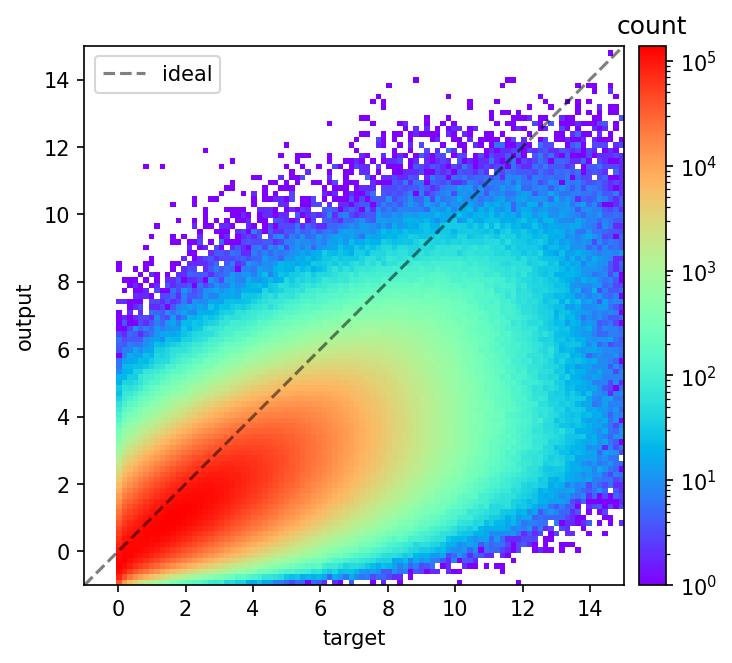

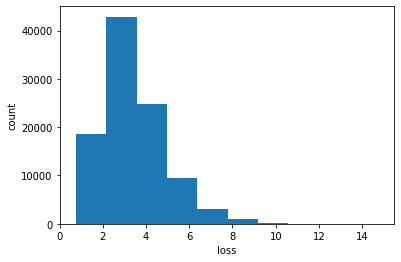

3.4280584


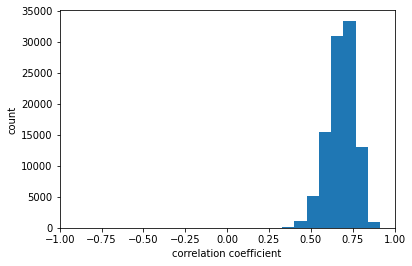

0.6824084131161454
optimizer: Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0
)
Epoch 1/20
val Loss:12.0096 Timer:10.3822
Epoch 2/20
train Loss:10.6934 Timer:230.0466
val Loss:10.0051 Timer:10.6970
Epoch 3/20
train Loss:9.6324 Timer:229.6656
val Loss:9.2225 Timer:11.4788
Epoch 4/20
train Loss:8.8148 Timer:228.7868
val Loss:8.4007 Timer:10.8435
Epoch 5/20
train Loss:8.0999 Timer:229.7648
val Loss:7.6767 Timer:18.1125


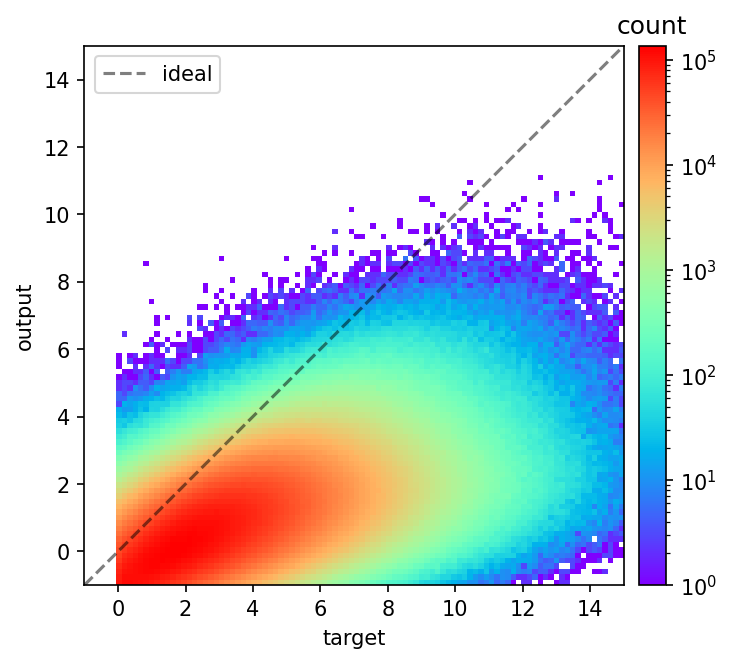

Epoch 6/20
train Loss:7.4631 Timer:230.1287
val Loss:7.1283 Timer:10.7344
Epoch 7/20
train Loss:6.8980 Timer:231.6913
val Loss:6.5790 Timer:10.7706
Epoch 8/20
train Loss:6.3954 Timer:230.9148
val Loss:6.0772 Timer:10.6573
Epoch 9/20
train Loss:5.9509 Timer:231.4956
val Loss:5.7047 Timer:10.7117
Epoch 10/20
train Loss:5.5601 Timer:228.5856
val Loss:5.3898 Timer:18.5758


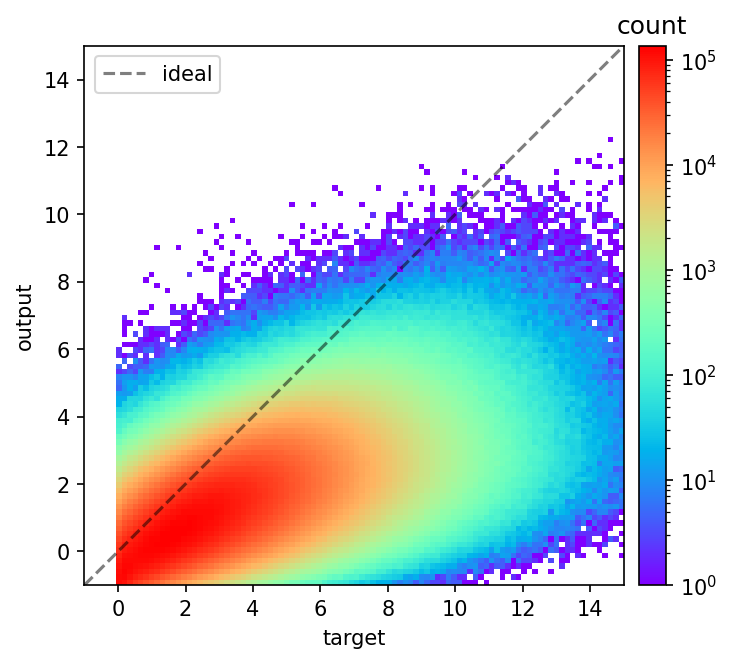

Epoch 11/20
train Loss:5.2169 Timer:231.9416
val Loss:4.9826 Timer:10.8093
Epoch 12/20
train Loss:4.9165 Timer:229.7318
val Loss:4.8247 Timer:10.7411
Epoch 13/20
train Loss:4.6557 Timer:231.2873
val Loss:4.5467 Timer:10.8738
Epoch 14/20
train Loss:4.4312 Timer:232.6269
val Loss:4.3190 Timer:10.7964
Epoch 15/20
train Loss:4.2398 Timer:230.1821
val Loss:4.1694 Timer:19.1734


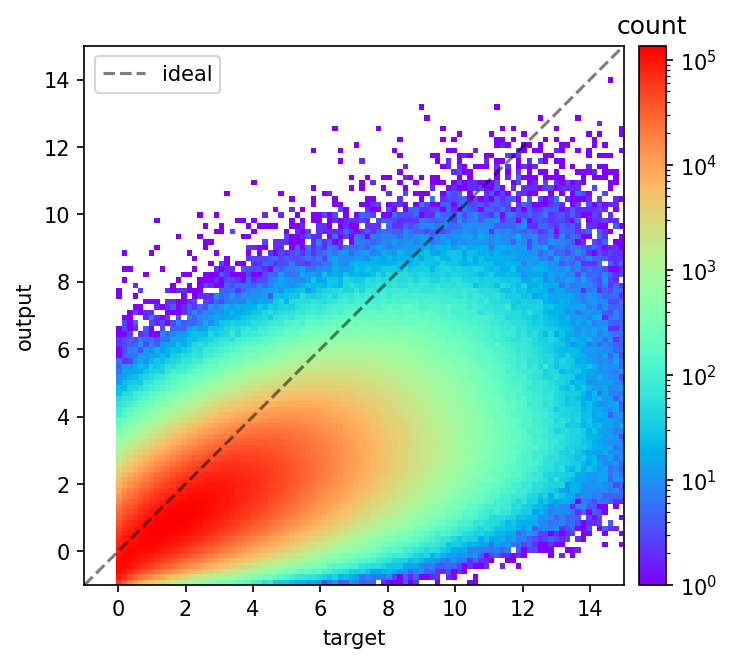

Epoch 16/20
train Loss:4.0787 Timer:229.5016
val Loss:4.0202 Timer:11.2475
Epoch 17/20
train Loss:3.9454 Timer:231.2779
val Loss:3.9177 Timer:10.7928
Epoch 18/20
train Loss:3.8377 Timer:234.8910
val Loss:3.7849 Timer:12.0961
Epoch 19/20
train Loss:3.7541 Timer:230.3033
val Loss:3.7326 Timer:10.7501
Epoch 20/20
train Loss:3.6936 Timer:231.6006
val Loss:3.6800 Timer:17.9297


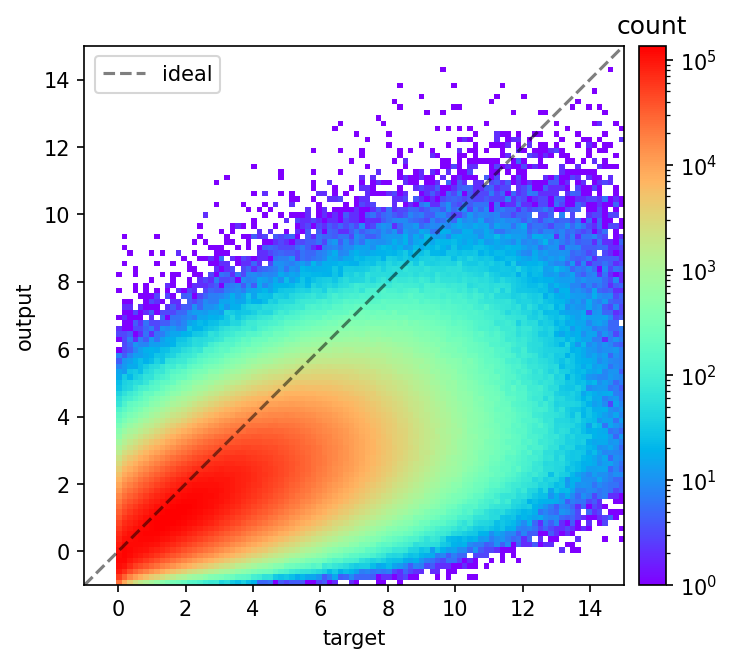

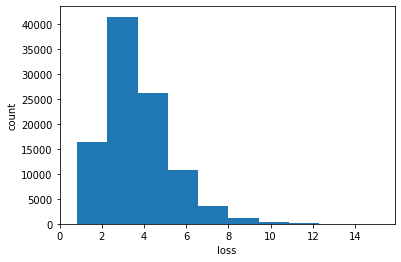

3.6799748


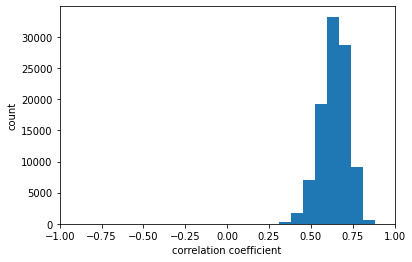

0.6410122850433527
optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
Epoch 1/20
val Loss:12.3976 Timer:10.5025
Epoch 2/20
train Loss:7.3306 Timer:228.0878
val Loss:4.5188 Timer:10.8294
Epoch 3/20
train Loss:3.3019 Timer:227.3679
val Loss:2.4999 Timer:10.8597
Epoch 4/20
train Loss:2.1455 Timer:229.7200
val Loss:1.9865 Timer:11.0081
Epoch 5/20
train Loss:1.9236 Timer:229.3403
val Loss:1.8978 Timer:19.8949


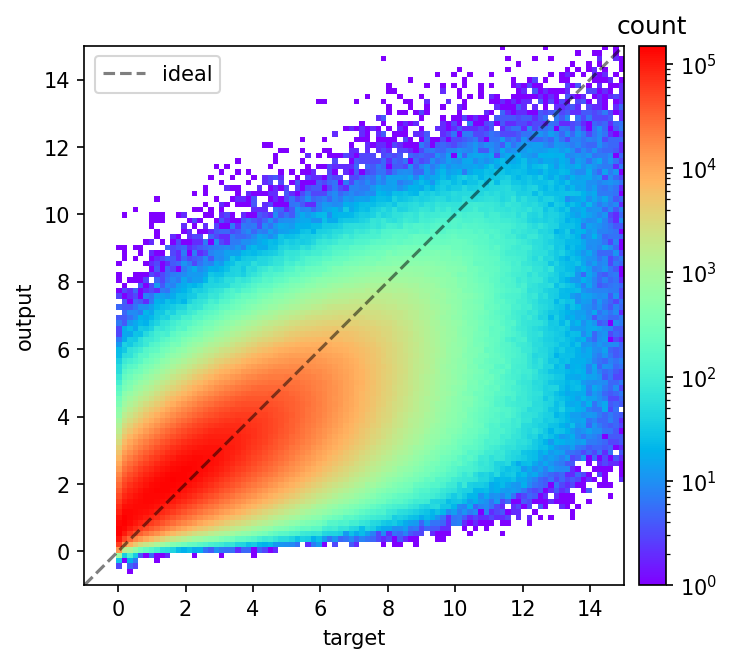

Epoch 6/20
train Loss:1.8457 Timer:225.8414
val Loss:1.8468 Timer:10.5363
Epoch 7/20
train Loss:1.7894 Timer:228.9522
val Loss:1.8005 Timer:10.7166
Epoch 8/20
train Loss:1.7444 Timer:225.4417
val Loss:1.7600 Timer:10.5654
Epoch 9/20
train Loss:1.7065 Timer:228.6005
val Loss:1.7228 Timer:11.4941
Epoch 10/20
train Loss:1.6742 Timer:229.7712
val Loss:1.7046 Timer:19.2524


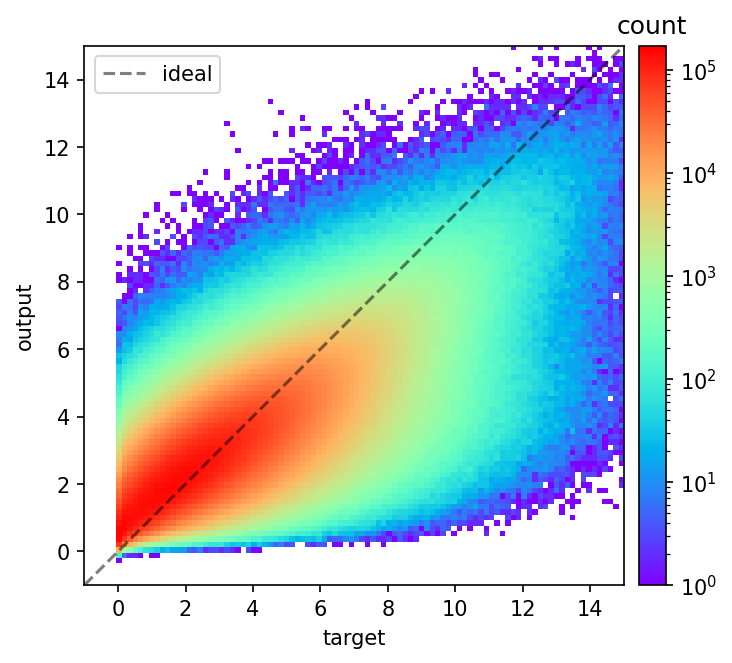

Epoch 11/20
train Loss:1.6456 Timer:226.8199
val Loss:1.6764 Timer:10.8120
Epoch 12/20
train Loss:1.6210 Timer:225.7424
val Loss:1.6588 Timer:10.7465
Epoch 13/20
train Loss:1.5985 Timer:230.3005
val Loss:1.6455 Timer:11.3198
Epoch 14/20
train Loss:1.5780 Timer:227.8851
val Loss:1.6252 Timer:10.7250
Epoch 15/20
train Loss:1.5593 Timer:226.9488
val Loss:1.6156 Timer:18.3971


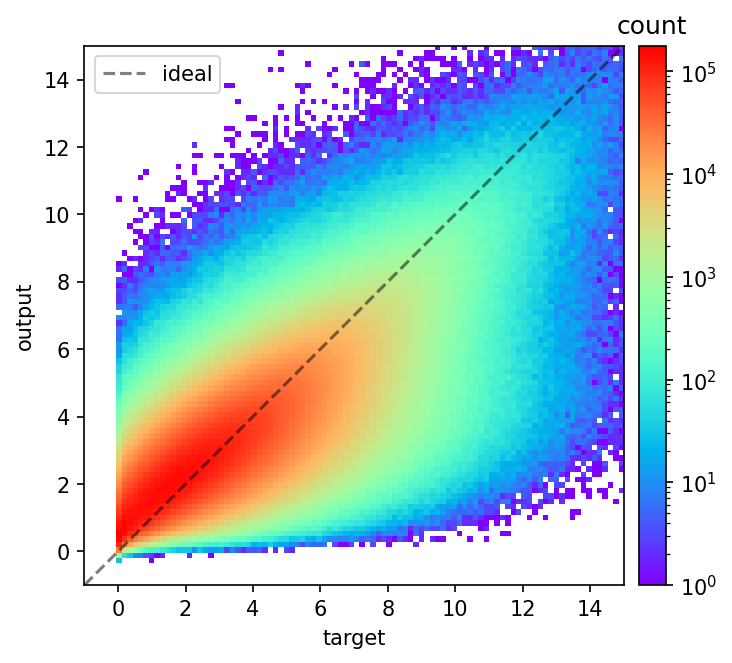

Epoch 16/20
train Loss:1.5421 Timer:226.5559
val Loss:1.6011 Timer:11.2682
Epoch 17/20
train Loss:1.5260 Timer:232.2295
val Loss:1.5922 Timer:11.4450
Epoch 18/20
train Loss:1.5110 Timer:233.2774
val Loss:1.5826 Timer:11.2441
Epoch 19/20
train Loss:1.4970 Timer:227.6866
val Loss:1.5799 Timer:10.6491
Epoch 20/20
train Loss:1.4836 Timer:226.8665
val Loss:1.5699 Timer:18.4777


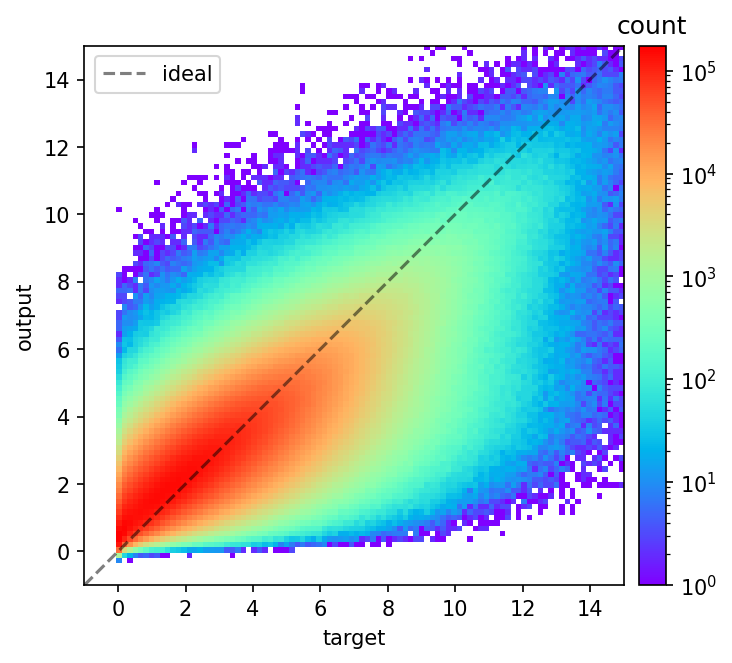

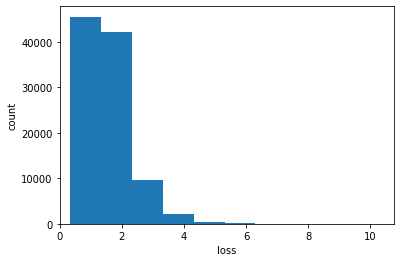

1.569879


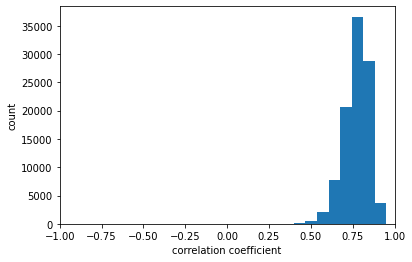

0.7727893924586018
optimizer: RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.001
    momentum: 0
    weight_decay: 0
)
Epoch 1/20
val Loss:16.0195 Timer:11.6782
Epoch 2/20
train Loss:7.0504 Timer:221.1819
val Loss:3.9502 Timer:10.9972
Epoch 3/20
train Loss:2.8801 Timer:221.8977
val Loss:2.3201 Timer:10.8774
Epoch 4/20
train Loss:2.1728 Timer:224.2361
val Loss:2.1304 Timer:10.6750
Epoch 5/20
train Loss:2.0400 Timer:222.5826
val Loss:2.0106 Timer:18.4112


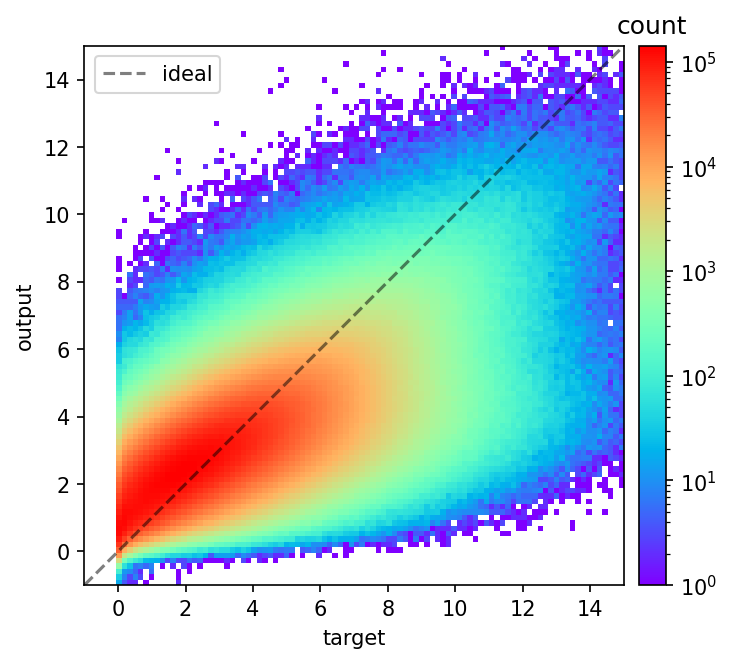

Epoch 6/20
train Loss:1.9526 Timer:223.1916
val Loss:1.9479 Timer:10.7439
Epoch 7/20
train Loss:1.8901 Timer:222.7007
val Loss:1.9045 Timer:10.7723
Epoch 8/20
train Loss:1.8411 Timer:223.5755
val Loss:1.8628 Timer:10.6436
Epoch 9/20
train Loss:1.8016 Timer:223.9484
val Loss:1.8121 Timer:10.7170
Epoch 10/20
train Loss:1.7696 Timer:223.1566
val Loss:inf Timer:18.2354


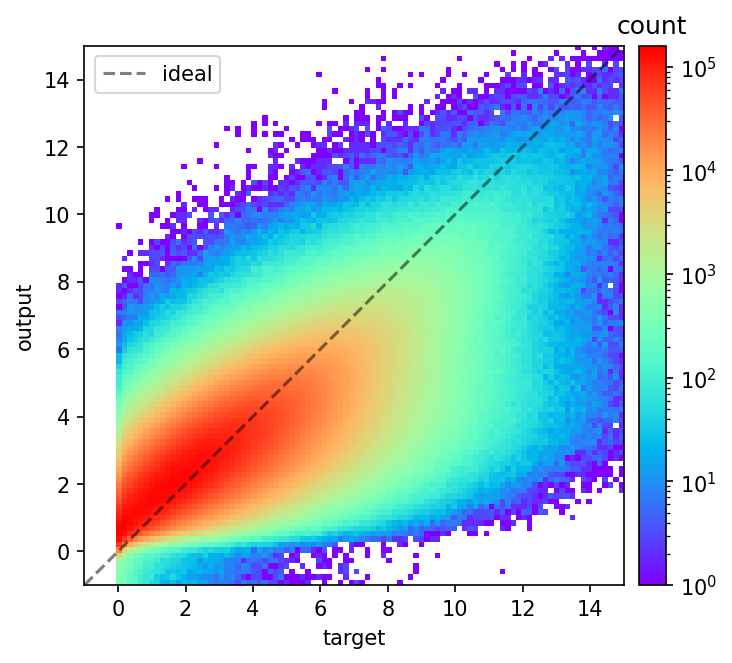

Epoch 11/20
train Loss:1.7415 Timer:224.1185
val Loss:1.7712 Timer:11.3528
Epoch 12/20
train Loss:1.7177 Timer:223.1358
val Loss:1.7491 Timer:11.2802
Epoch 13/20
train Loss:1.6967 Timer:223.9922
val Loss:1.7360 Timer:11.1964
Epoch 14/20
train Loss:1.6776 Timer:223.8210
val Loss:1.7177 Timer:11.4405
Epoch 15/20
train Loss:1.6606 Timer:225.8187
val Loss:1.7101 Timer:18.1472


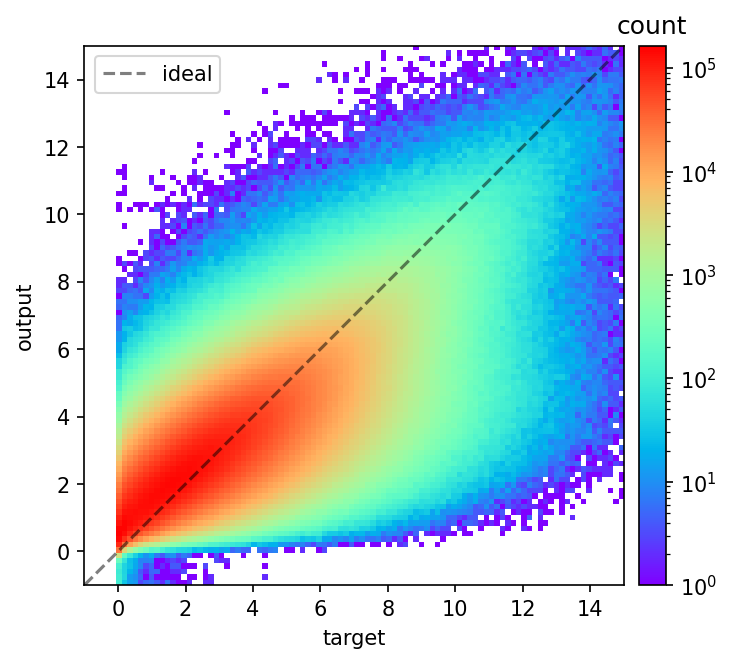

Epoch 16/20
train Loss:1.6453 Timer:225.0763
val Loss:1.6887 Timer:11.2850
Epoch 17/20
train Loss:1.6315 Timer:223.0334
val Loss:1.6732 Timer:13.0121
Epoch 18/20
train Loss:1.6192 Timer:228.4377
val Loss:1.6650 Timer:11.6027
Epoch 19/20
train Loss:1.6082 Timer:221.7128
val Loss:1.6573 Timer:11.0936
Epoch 20/20
train Loss:1.5985 Timer:223.1063
val Loss:1.6498 Timer:18.5396


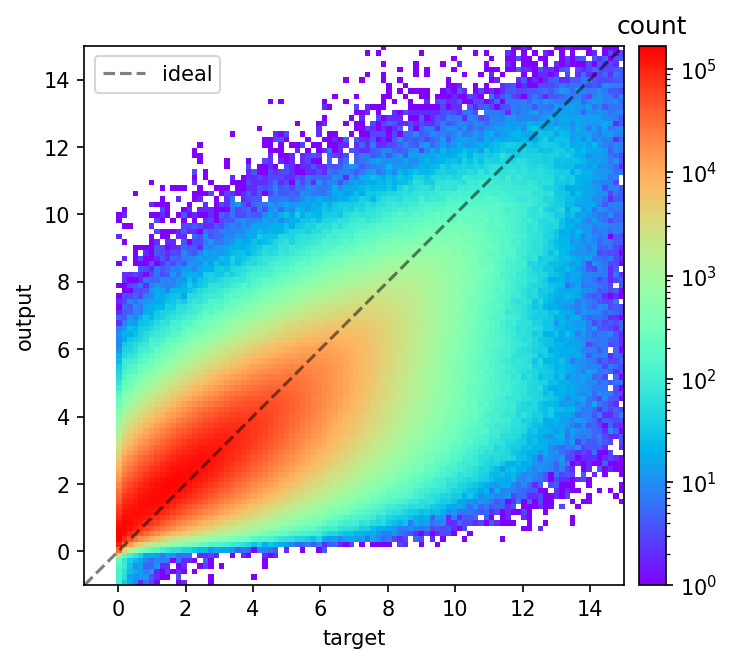

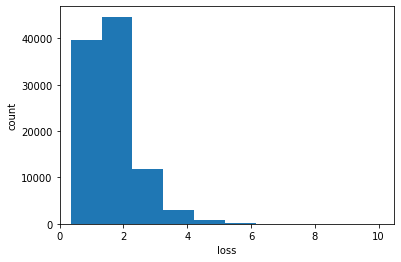

1.649816


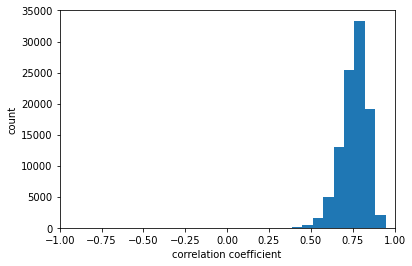

0.7596531450570158
optimizer: Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
Epoch 1/20
val Loss:12.1149 Timer:10.4096
Epoch 2/20
train Loss:7.2519 Timer:230.3589
val Loss:4.4055 Timer:10.7791
Epoch 3/20
train Loss:3.0306 Timer:229.1769
val Loss:2.3867 Timer:10.9695
Epoch 4/20
train Loss:2.2937 Timer:231.2089
val Loss:2.2406 Timer:11.4622
Epoch 5/20
train Loss:2.1716 Timer:229.7744
val Loss:2.1425 Timer:18.0288


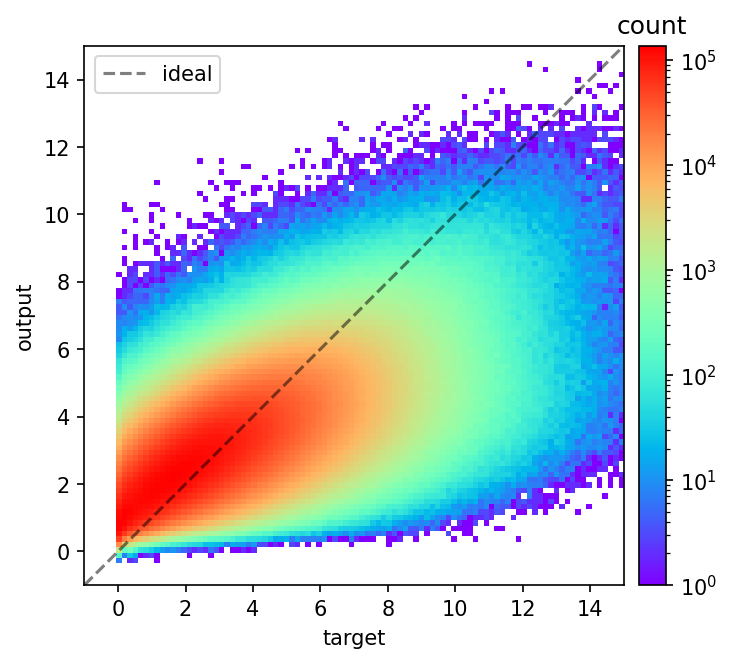

Epoch 6/20
train Loss:2.0905 Timer:229.9753
val Loss:2.0772 Timer:10.8245
Epoch 7/20
train Loss:2.0288 Timer:230.3783
val Loss:2.0342 Timer:10.6931
Epoch 8/20
train Loss:1.9804 Timer:232.3792
val Loss:1.9989 Timer:10.7422
Epoch 9/20
train Loss:1.9402 Timer:232.2894
val Loss:1.9529 Timer:11.2690
Epoch 10/20
train Loss:1.9067 Timer:230.4332
val Loss:1.9281 Timer:18.7675


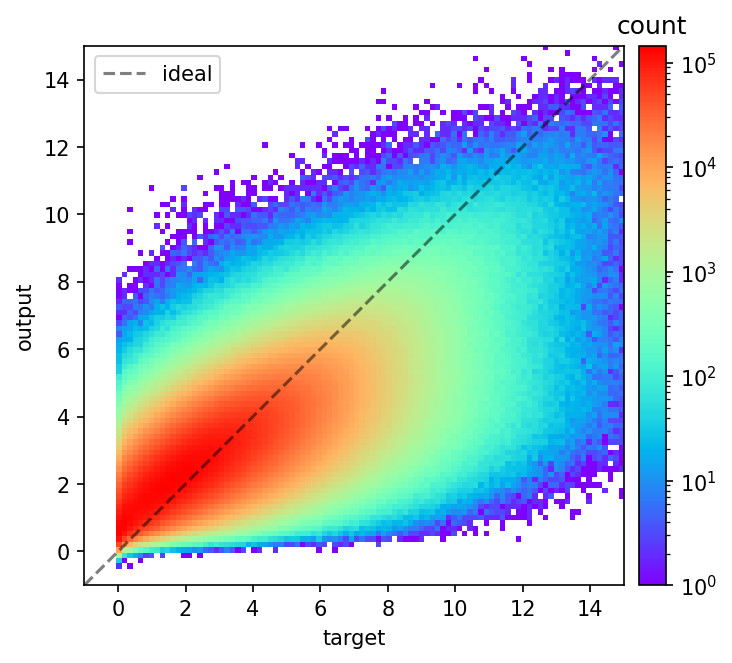

Epoch 11/20
train Loss:1.8778 Timer:229.2711
val Loss:1.9097 Timer:10.8075
Epoch 12/20
train Loss:1.8526 Timer:232.4203
val Loss:1.8892 Timer:10.8009
Epoch 13/20
train Loss:1.8307 Timer:229.0157
val Loss:1.8744 Timer:10.6714
Epoch 14/20
train Loss:1.8109 Timer:231.8416
val Loss:1.8685 Timer:11.2865
Epoch 15/20
train Loss:1.7930 Timer:232.5164
val Loss:1.8524 Timer:18.2577


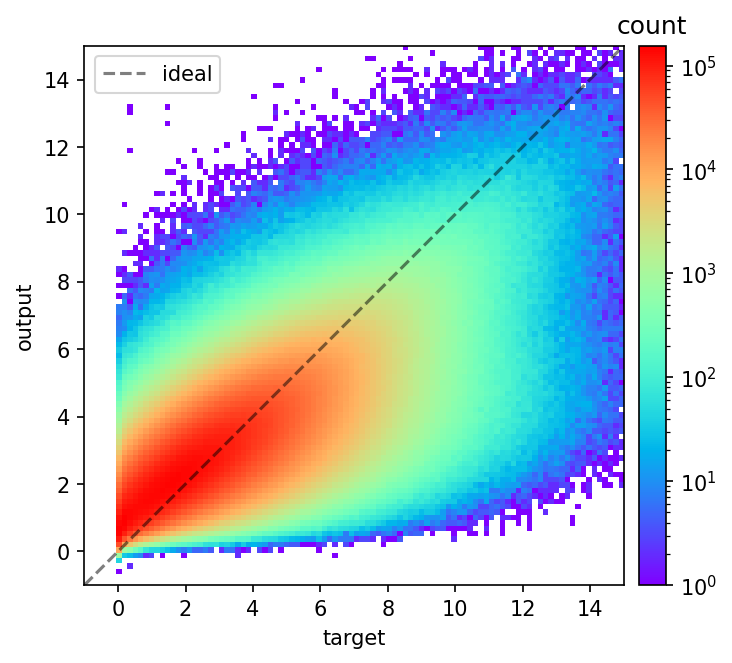

Epoch 16/20
train Loss:1.7772 Timer:231.6021
val Loss:1.8467 Timer:10.8932
Epoch 17/20
train Loss:1.7627 Timer:229.4371
val Loss:1.8336 Timer:12.7710
Epoch 18/20
train Loss:1.7495 Timer:235.7589
val Loss:1.8262 Timer:11.3696
Epoch 19/20
train Loss:1.7375 Timer:231.5491
val Loss:1.8219 Timer:11.2213
Epoch 20/20
train Loss:1.7268 Timer:233.3152
val Loss:1.8165 Timer:19.5087


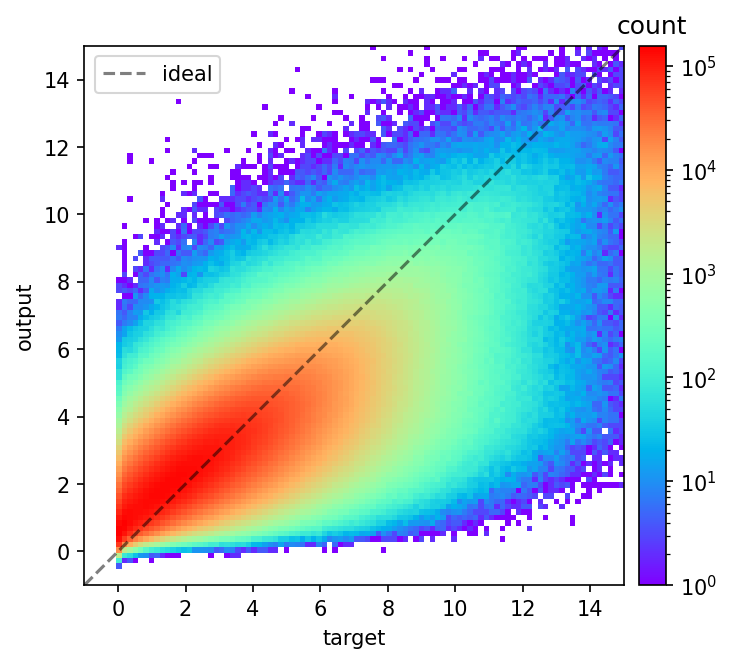

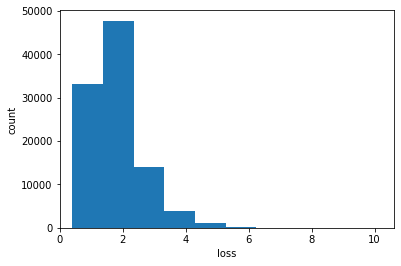

1.8164616


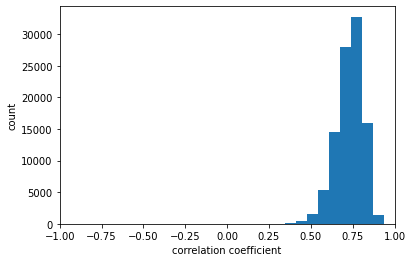

0.7307415768333958


In [12]:
batch_size = 256
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
dataloaders_dict = {'train': train_dataloader, 'val': val_dataloader}

for loss in losses:
    for lr in lrs:
        for opt in opts:
            net = model.Variable(num_layer=8, num_filters=128, kernel_sizes=5).to(device)
            net.apply(model.weight_init) #重みの初期化適用
            #         print(summary(net, input_size=([batch_size, 512])))
            #         reporter = MemReporter(net)
            #         reporter.report()
            #ファインチューニング
            #         optimizer = optim.Adam([{'params': net.embedding.parameters(), 'lr': 5e-4},
            #                                 {'params': net.convs.parameters(), 'lr': 1e-4},
            #                                 {'params': net.mid.parameters(), 'lr': 5e-4},
            #                                 {'params': net.fc.parameters(), 'lr': 1e-3}], weight_decay=1e-6)
            optimizer = opt(net.parameters(), lr=lr)
            print(f'optimizer: {optimizer}')
            epochs = 20
            criterion = loss().to(device)
            #         # 学習途中データ
            #         checkpoint = torch.load('max_span100.pth')
            #         net.load_state_dict(checkpoint['model_state_dict'])
            #         optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            #         epochs = checkpoint['epoch']
            #         loss = checkpoint['loss']
            scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_epoch)
            train_loss_list, val_loss_list, data_all, target_all, output_all = mode.train(device, net, dataloaders_dict, criterion, optimizer, epochs, scheduler)               
            torch.save(net.state_dict(), 'tmp.pth')

            #         print(f'memory report')
            #         reporter.report()

        #     result.learning_curve(train_loss_list, val_loss_list, epochs[1:])
        #     result.plot_result(np.array(target_all, dtype=object).reshape(-1), np.array(output_all, dtype=object).reshape(-1))
            cor_list, loss_list = result.cal_indicators(target_all, output_all)
            result.loss_hist(loss_list)
            result.cor_hist(cor_list)
        #     loss_sort, cor_sort = result.sort_list(loss_list, cor_list)
        #     dic = {'best loss': loss_sort[0],  'worst loss': loss_sort[-1], '10th bad loss': loss_sort[-10],'100th bad loss': loss_sort[-100],
        #               'best cor': cor_sort[-1], 'worst cor': cor_sort[0], '10th bad cor': cor_sort[9],'100th bad cor': cor_sort[99]} 
        #     for k, v in dic.items():
        #         print(k)
        #         result.visible_one(target_all, output_all, data_all, loss_list, cor_list, idx=v)

In [ ]:
# # 作りたてほやほやをinputとtargetに渡すよ
# input_array = []
# target_array = []
# for i in range(10):
#     input_path = f"../data/makedata/val/index/input_{i+1}.csv"
#     target_path = f"../data/makedata/val/accessibility/target_{i+1}.csv"
#     input_array.append(torch.Tensor(np.loadtxt(input_path, delimiter=",", dtype=np.float).astype(np.int)))
#     target_array.append(torch.Tensor(np.loadtxt(target_path, delimiter=",", dtype=np.float)))


In [ ]:
# input_test = pickle.load(open("../data/test_sets/input_600_1000.pkl","rb"))
# target_test = pickle.load(open("../data/test_sets/target_600_1000.pkl","rb"))
# input_test = pickle.load(open("../data/RF00156/input_RF00156.pkl","rb"))
# target_test = pickle.load(open("../data/RF00156/target_RF00156.pkl","rb"))
# input_test = torch.stack(input_array)
# target_test = torch.stack(target_array)

# target_test = torch.flip(target_test, dims=[1])

input_test = pickle.load(open("../data/max_span100_512/input_val15.pkl","rb"))
target_test = pickle.load(open("../data/max_span100_512/target_val15.pkl","rb")) #512のみ
target_test = torch.flip(target_test, dims=[1])
# input_test = input_test[0:10000] 
# target_test = target_test[0:10000]

datePrint(input_test.shape)
datePrint(target_test.shape)

test_dataset = model.Dataset(input_test, target_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32,shuffle=False, num_workers=1)

net = model.dilation1(num_layer=16, num_filters=128, kernel_sizes=5).to(device)
net.load_state_dict(torch.load('big_data.pth'))
criterion = nn.MSELoss().to(device)

start = time.time()
test_loss, data_all, target_all, output_all = mode.test(device, net, test_dataloader, criterion) 
datePrint('finish prediction loss', test_loss)
    
# np.savetxt('accessibility_output.txt', output_all, fmt='%.3e')
finish = time.time()
datePrint('予測時間', (finish-start))

In [ ]:
result.plot_result(np.array(target_all, dtype=object).reshape(-1), np.array(output_all, dtype=object).reshape(-1))
cor_list, loss_list = result.cal_indicators(target_all, output_all)
result.loss_hist(loss_list)
result.cor_hist(cor_list)
loss_sort, cor_sort = result.sort_list(loss_list, cor_list)
dic = {'best loss': loss_sort[0],  'worst loss': loss_sort[-100], 'best cor': cor_sort[-1], 'worst cor': cor_sort[100]} 
for k, v in dic.items():
    print(k)
    result.visible_one(target_all, output_all, data_all, loss_list, cor_list, idx=v)

In [ ]:
loss_target, loss_output, loss_data, cor_target, cor_output, cor_data = result.remake_bad(target_all, output_all, data_all, loss_sort, cor_sort, length=1000)
result.plot_result(np.array(loss_target, dtype=object).reshape(-1), np.array(loss_output, dtype=object).reshape(-1))
result.plot_result(np.array(cor_target, dtype=object).reshape(-1), np.array(cor_output, dtype=object).reshape(-1))

In [ ]:
def count_diff(data_all):
    diff_list = []
    for i in data_all:
        count_A, count_U, count_G, count_C = 0, 0, 0, 0
        count_A += np.count_nonzero(i==1)
        count_U += np.count_nonzero(i==2)
        count_G += np.count_nonzero(i==3)
        count_C += np.count_nonzero(i==4)
#         diff = abs(count_A-len(i)/4) + abs(count_U-len(i)/4) + abs(count_G-len(i)/4) + abs(count_C-len(i)/4)
        diff = count_G-len(i)/4
        diff_list.append(diff)

    return diff_list

_, loss_list = result.cal_indicators(loss_target, loss_output)
diff_list = count_diff(loss_data)
result.heat_scatter(diff_list, loss_list)

cor_list, _ = result.cal_indicators(cor_target, cor_output)
diff_list = count_diff(cor_data)
result.heat_scatter(diff_list, cor_list)

# diff_list = count_diff(data_all)
# result.heat_scatter(diff_list, loss_list)
# result.heat_scatter(diff_list, cor_list)

In [ ]:
diff_list = result.count_diff(data_all)
result.heat_scatter(diff_list, loss_list)
result.heat_scatter(diff_list, cor_list)

_, loss_bad = result.cal_indicators(loss_target, loss_output)
diff_list = result.count_diff(loss_data)
result.heat_scatter(diff_list, loss_bad)

cor_bad, _ = result.cal_indicators(cor_target, cor_output)
diff_list = result.count_diff(cor_data)
result.heat_scatter(diff_list, cor_bad)

In [ ]:
start = time.time()
path = "../data/human_data/seq7.fa"
with open(path, mode = 'r', encoding = 'utf-8') as f:
    seq_file = f.read().splitlines()
indexes = [i for i, n in enumerate(seq_file) if n.startswith('>')]
name = seq_file[0]
seq = ''.join(seq_file[1:]).replace('A', '1').replace('T', '2').replace('U', '2').replace('G', '3').replace('C', '4')
input_seq = torch.Tensor(list(map(int, seq)))
input_seq = torch.flip(input_seq, dims=[0])
input_seq = input_seq.unsqueeze(0)
out_length = len(input_seq[0])-4

input_seq = input_seq.unsqueeze(0)

net = model.dilation1(num_layer=16, num_filters=128, kernel_sizes=5).to(device)
net.load_state_dict(torch.load('big_data.pth'))
    
data_all, output_all = mode.predict(device, net, input_seq) 

  
import matplotlib.pyplot as plt
max_length = output_all.shape[1]
with open('../data/human_data/out7.txt', 'r') as f:
        next(f)
        acc = f.readlines()
        acc_list = []
        for i in range(len(acc)-1):
                acc_list.append(re.findall(',(.*);', acc[i])[0])
acc_list = [float(x) for x in acc_list]

plt.figure(figsize=(15, 7))
plt.plot(range(out_length), acc_list, label='target', color='b')
plt.plot(range(out_length), output_all[0][:out_length], label='output', color='r')
plt.legend()
plt.xlabel('base position')
plt.ylabel('accessibility')
plt.title('one')
plt.show()


cor = np.corrcoef(acc_list, output_all[0][:out_length])
mse = ((acc_list - output_all[0][:out_length])**2).mean(axis=0)
print('cor', cor[0,1])
print('mse', mse)

    
np.savetxt('accessibility_output.txt', output_all, fmt='%.3f')
finish = time.time()
datePrint('予測時間', (finish-start))

In [ ]:
path = "../data/real_data/RF00156.fa"

start = time.time()
with open(path, mode = 'r', encoding = 'utf-8') as f:
    seq_file = f.read().splitlines()
indexes = [i for i, n in enumerate(seq_file) if n.startswith('>')]
name_list = []
seq_list = torch.empty(0, 256)

for i in range(len(indexes)-1):
    name_list.append(seq_file[indexes[i]])
    seq = ''.join(seq_file[indexes[i]+1:indexes[i+1]]).replace('A', '1').replace('T', '2').replace('U', '2').replace('G', '3').replace('C', '4').replace('N', '0')
    seq = torch.Tensor(list(map(int, seq)))
    seq = torch.flip(seq, dims=[0])
    if (seq.shape[0]%256 != 0):
        seq = F.pad(seq, (0, 256-seq.shape[0]%256))
    seq = seq.unsqueeze(0)
    seq_list = torch.cat([seq_list, seq], dim=0)


# if (input_seq.shape[1]%256 != 0):
#     input_seq = F.pad(input_seq, (0, 256-input_seq.shape[1]%256))
# if (input_seq.shape[1]>256):
#     transform = True
#     division = (input_seq.shape[1])//128 - 1
#     input_init = input_seq
#     input_seq = input_seq.unfold(1, 256, 128).reshape(-1, 256)
# else:
#     transform = False
# datePrint(input_seq.shape)
# input_seq = input_seq.unsqueeze(0)
# datePrint(input_seq.shape)

seq_list = seq_list.unsqueeze(0)
net = model.Variable(num_layer=16, kernel_sizes=33, flag=False).to(device)
net.load_state_dict(torch.load('max_span20.pth'))
    
data_all, output_all = mode.predict(device, net, seq_list) 
# if (transform==True):
#     output_tmp = torch.tensor(output_all)
#     for n in range(division):
#         if (n==0):
#             output_all = output_tmp[n::division, :192]
#         elif (n==division-1):
#             output_all = torch.cat([output_all, output_tmp[n::division, 64:]], dim=1)
#         else:
#             output_all = torch.cat([output_all, output_tmp[n::division, 64:192]], dim=1)
    
#     data_all = input_init.numpy()
#     output_all = output_all.numpy()
    
np.savetxt('accessibility_output.txt', output_all, fmt='%.3f')
finish = time.time()
datePrint('予測時間', (finish-start))

In [ ]:
# sample作成
path = "../data/RF01210/RF01210.fa"

with open(path, mode = 'r', encoding = 'utf-8') as f:
    seq_file = f.read().splitlines()
indexes = [i for i, n in enumerate(seq_file) if n.startswith('>')]

for i in range(len(indexes)-1):
    with open(f"../data/RF01210/sample_{i}.txt", mode="w") as f:
        f.write(seq_file[indexes[i]] + "\n")
        f.write(''.join(seq_file[indexes[i]+1:indexes[i+1]]))

In [ ]:
# castしちゃう
from pathlib import Path
import numpy as np
from tqdm import tqdm
import pickle
import torch
import sys

for cond, cnt in (("train", 500000), ("test", 500000)):
    data_path = Path(f"../data/makedata/{cond}")
    input_array = []
    target_array = []
    print(f"reading {cond} files")
    for i in tqdm(range(cnt)):
        input_path = data_path / f"index/input_{i+1}.csv"
        target_path = data_path / f"accessibility/target_{i+1}.csv"

        input_array.append(torch.Tensor(np.loadtxt(input_path, delimiter=",", dtype=np.float).astype(np.int)))
        target_array.append(torch.Tensor(np.loadtxt(target_path, delimiter=",", dtype=np.float)))
    print(f"saving to input_{cond}.pkl")
    pickle.dump(torch.stack(input_array), open(f"../data/input_{cond}.pkl", 'wb'))
        
    print(f"saving to target_{cond}.pkl")
    pickle.dump(torch.stack(target_array), open(f"../data/target_{cond}.pkl", 'wb'))
